In [1]:
from visual_transformer import *

In [2]:
torch.cuda.is_available()

True

In [3]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

Tesla P40


/home/atbolsh/anaconda3/envs/player/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
device = torch.device('cuda:0') # the big machine

In [5]:
brain = DefaultAgentBrain().to(device)

In [6]:
# Trying to continue the v6 training, but with a lower lr:
brain.img_enc.load_state_dict(torch.load('brain_checkpoints/img_encoder_weights_v9_batch170599.pth', weights_only=True))
brain.img_dec.load_state_dict(torch.load('brain_checkpoints/img_decoder_weights_v9_batch170599.pth', weights_only=True))

<All keys matched successfully>

In [7]:
from game import *

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [8]:
game_settings = BIG_tool_use_advanced_2_5
game_settings.gameSize = 224 # for compatibility with brain's expected size
G = discreteGame(game_settings)

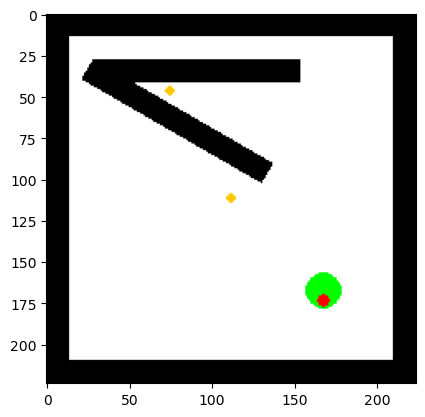

In [9]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [10]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [11]:
criterion = nn.MSELoss()

In [12]:
optimizer = optim.Adam(brain.parameters(), lr=0.00001, eps=1e-9) #0.0001, betas=(0.9, 0.98), eps=1e-9)
# v7 is piggy-backing off v6 (batch 9499), using an lr of 1e-5 (ten times lower than v6)
# Will see if it can significantly improve on the loss (just below 1e-3 for the best of v6)
# v8 piggy-backs off of v7 in the same way (same lr, though; v7 was terminated by accident)
# v9 piggy-backs off of v8 (same lr, had to restart for infrastructure reasons)
# 

In [13]:
import time

total_batches = 6250*32

total_loss = 0
brain.train()
curr_min = 1.0
for b in range(total_batches):
    if b == 0:
        start = time.time()
    img_set = G.random_full_image_set(restrict_angles=True)
    img_tensor = torch.permute(torch.FloatTensor(img_set).to(device), (0, 3, 1, 2))
    batch_size = img_tensor.size()[0]
    text_context = torch.randn((batch_size, 32, 768), device=device) # easier for pretraining to use randn
    recon = brain.img_autoencoder(img_tensor, text_context)
    loss = criterion(recon, img_tensor)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
    if b == 0:
        runtime = time.time() - start
        print(f"Time for 1 batch: {runtime} seconds")
    if (b % 100 == 99):
        avg_loss = total_loss / 100
        if avg_loss < curr_min:
            curr_min = avg_loss
            torch.save(brain.img_enc.state_dict(), f'brain_checkpoints/img_encoder_weights_v10_batch{b}.pth')
            torch.save(brain.img_dec.state_dict(), f'brain_checkpoints/img_decoder_weights_v10_batch{b}.pth')
        total_loss = 0
        print(f"Avg loss for last 100 batches, at batch {b + 1}: {avg_loss}")

/home/atbolsh/anaconda3/envs/player/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Time for 1 batch: 2.4009592533111572 seconds
Avg loss for last 100 batches, at batch 100: 0.0002448403005837463
Avg loss for last 100 batches, at batch 200: 0.00024403954535955562
Avg loss for last 100 batches, at batch 300: 0.00024620290278107857
Avg loss for last 100 batches, at batch 400: 0.0002442488438100554
Avg loss for last 100 batches, at batch 500: 0.0002462296833982691
Avg loss for last 100 batches, at batch 600: 0.00024479354076902384
Avg loss for last 100 batches, at batch 700: 0.0002453916103695519
Avg loss for last 100 batches, at batch 800: 0.0002466404007282108
Avg loss for last 100 batches, at batch 900: 0.0002468943558051251
Avg loss for last 100 batches, at batch 1000: 0.00024474172911141066
Avg loss for last 100 batches, at batch 1100: 0.0002448739753162954
Avg loss for last 100 batches, at batch 1200: 0.00024516460136510433
Avg loss for last 100 batches, at batch 1300: 0.000245880312868394
Avg loss for last 100 batches, at batch 1400: 0.00024422256930847655
Avg los

KeyboardInterrupt: 

In [14]:
curr_min

0.0002371365117141977

In [ ]:
# 17 gigs for this. Nice and easy. I probably have enough left over to also run text training on the same device! 
# But there's no reason to push it.

In [ ]:
# I'll kill it after just one day and check on the results. If I like what I see, I'll keep it. Otherwise, I'll either
# let it continue or tweak some things and restart this.

In [ ]:
# v5 *almost* did it, but my code was clumsy so the results got over-written
# I'm rerunning this, saving relevant epochs.

In [ ]:
img_set = G.random_full_image_set(restrict_angles=True)
img_tensor = torch.permute(torch.FloatTensor(img_set).to(device), (0, 3, 1, 2))

In [ ]:
batch_size = img_tensor.size()[0]

In [ ]:
text_context = torch.randn((batch_size, 32, 768), device=device)

In [ ]:
recon = brain.img_autoencoder(img_tensor, text_context)

In [ ]:
# v9 is very very good. Will train it just a little more in case it gets better, but I'm not getting my hopes up.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16818222..1.2612754].


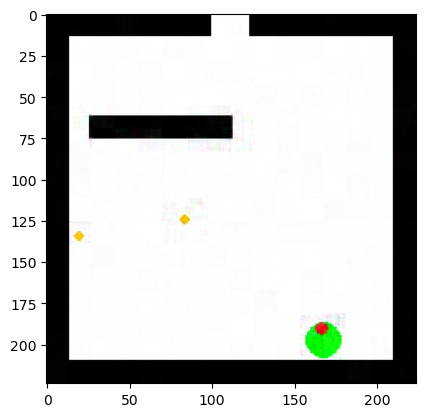

In [15]:
quick_display(recon[17])

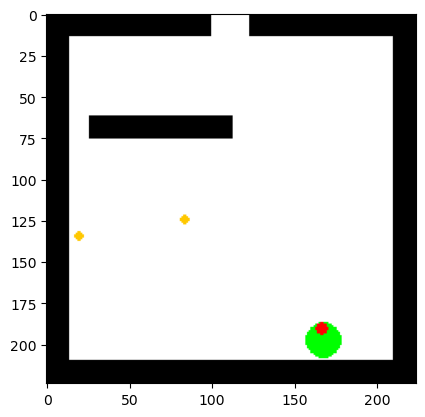

In [16]:
quick_display(img_tensor[17])

In [ ]:
 # It almost looks like it can't tell where anything is.

In [ ]:
a = torch.randn((1, 256, 768), device=device)

In [ ]:
b = brain.img_enc.embed[1](a)

In [ ]:
a

In [ ]:
b

In [ ]:
c = b - a * math.sqrt(768)
c

In [ ]:
torch.mean(c)

In [ ]:
math.sqrt(768)

In [ ]:
23200 * 40